In [ ]:
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS
import jax.numpy as jnp
import jax.random as random
import matplotlib.pyplot as plt

In [2]:
# -----------------------------
# RNGキーとチェーンの設定
# -----------------------------
rng_key = random.PRNGKey(0)
num_chains = 3
rng_keys = random.split(rng_key, num_chains)

# -----------------------------
# データ生成（平均1の単一正規分布）
# -----------------------------
n_samples = 1000
x_data = dist.Normal(1, 1).sample(rng_key, (n_samples,))  # 観測データ

# -----------------------------
# モデル定義（平均muを推定）
# -----------------------------
def model(x):
    mu = numpyro.sample("mu", dist.Normal(-1, 1))  # muの事前分布：平均-1, 分散1
    with numpyro.plate("data", len(x)):
        numpyro.sample("obs", dist.Normal(mu, 1.0), obs=x)  # 観測モデル：分散は既知で1

# -----------------------------
# MCMCによるサンプリング
# -----------------------------
nuts_kernel = NUTS(model)
mcmc = MCMC(nuts_kernel, num_warmup=2000, num_samples=2000, num_chains=num_chains)
mcmc.run(rng_keys, x=x_data)
mcmc.print_summary()

# -----------------------------
# 事後サンプルの取得（チェーンごと）
# -----------------------------
posterior_samples = mcmc.get_samples(group_by_chain=True)  # shape: [num_chains, num_samples]

/var/folders/j2/47mcq61x0n9cn6gkxl48ypbr0000gn/T/ipykernel_74238/1403376117.py:26: UserWarning: There are not enough devices to run parallel chains: expected 3 but got 1. Chains will be drawn sequentially. If you are running MCMC in CPU, consider using `numpyro.set_host_device_count(3)` at the beginning of your program. You can double-check how many devices are available in your system using `jax.local_device_count()`.
  mcmc = MCMC(nuts_kernel, num_warmup=2000, num_samples=2000, num_chains=num_chains)
sample: 100%|██████████| 4000/4000 [00:00<00:00, 5595.22it/s, 1 steps of size 1.05e+00. acc. prob=0.92]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        mu      1.00      0.03      1.00      0.95      1.05   2044.94      1.00

Number of divergences: 0


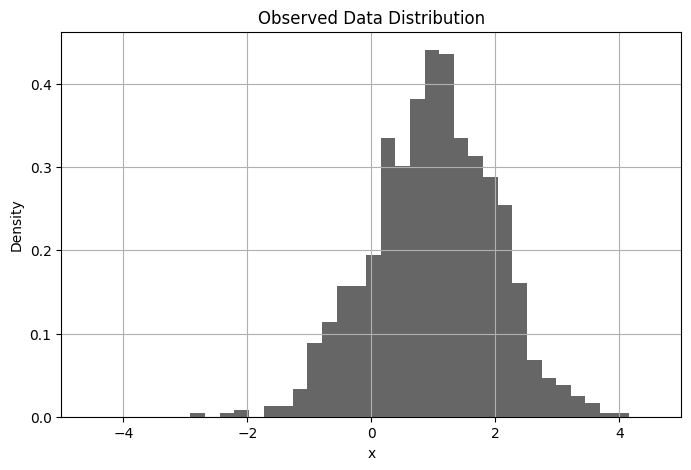

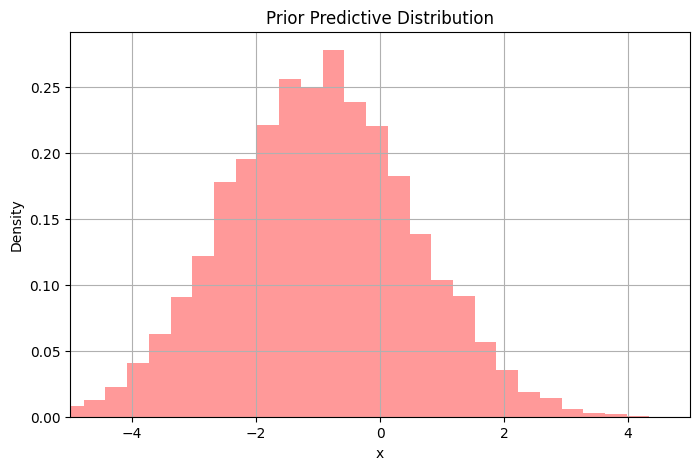

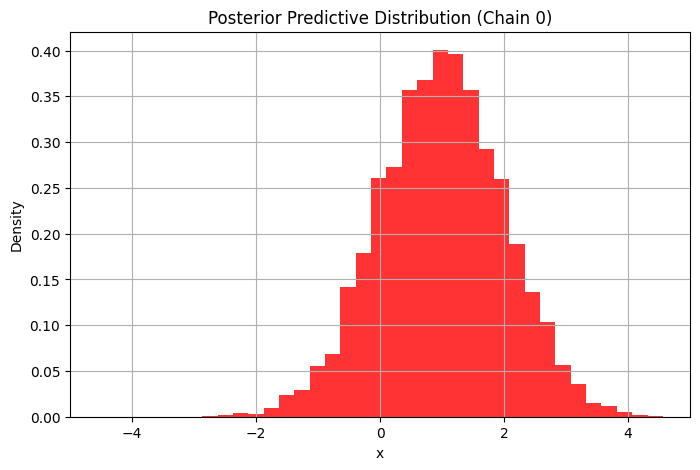

In [3]:
# -----------------------------
# 描画①: 観測データの分布
# -----------------------------
plt.figure(figsize=(8, 5))
plt.hist(x_data, bins=30, density=True, color="black", alpha=0.6)
plt.title("Observed Data Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.xlim(-5, 5)
plt.grid(True)
plt.show()

# -----------------------------
# 描画②: 事前予測分布（muの事前サンプルから生成）
# -----------------------------
prior_key = random.PRNGKey(1)
num_prior_mu = 100
samples_per_mu = 50

prior_mu_samples = dist.Normal(-1, 1).sample(prior_key, (num_prior_mu,))  # muの事前サンプル
prior_x_samples = []

for i in range(num_prior_mu):
    subkey = random.fold_in(prior_key, i)
    x_prior = dist.Normal(prior_mu_samples[i], 1).sample(subkey, (samples_per_mu,))
    prior_x_samples.append(x_prior)

prior_x_samples = jnp.concatenate(prior_x_samples)

plt.figure(figsize=(8, 5))
plt.hist(prior_x_samples, bins=30, density=True, color="red", alpha=0.4)
plt.title("Prior Predictive Distribution")
plt.xlabel("x")
plt.ylabel("Density")
plt.xlim(-5, 5)
plt.grid(True)
plt.show()

# -----------------------------
# 描画③: 事後予測分布（muはChain 0のサンプルを使用）
# -----------------------------
posterior_mu_chain0 = posterior_samples["mu"][0]  # チェーン0のmuサンプル
posterior_x_samples = []

for i in range(100):
    subkey = random.fold_in(prior_key, 1000 + i)  # 乱数キーを分離
    x_post = dist.Normal(posterior_mu_chain0[i], 1).sample(subkey, (50,))
    posterior_x_samples.append(x_post)

posterior_x_samples = jnp.concatenate(posterior_x_samples)

plt.figure(figsize=(8, 5))
plt.hist(posterior_x_samples, bins=30, density=True, color="red", alpha=0.8)
plt.title("Posterior Predictive Distribution (Chain 0)")
plt.xlabel("x")
plt.ylabel("Density")
plt.xlim(-5, 5)
plt.grid(True)
plt.show()